In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats

In [3]:
file_path = '/content/drive/My Drive/Markdown Management/data_for_MarkdownManagementAtSportsUnlimited.xlsx'
df = pd.read_excel(file_path)

In [4]:
df.head()

,ID,Branded?,Buyer,Vendor,Cost,1st Ticket Price,1st Markdown %,1st Week of Lifecycle,1st Markdown in Week #,Unite Sales by Week 3,Units Sales,Dollar Sales,Lifecycle Length,Units Salvaged
0,1,1,1005,61,84.925,197.5,50.0,6,17.0,2.109890,12,1536.0,26,4
1,2,0,1011,83,144.375,460.0,NaN,46,NaN,5.000000,13,6070.0,8,3
2,3,1,1011,85,67.825,172.5,NaN,46,NaN,7.000000,16,2710.0,8,2
3,4,1,1011,85,63.575,172.5,NaN,41,NaN,5.000000,15,2540.0,8,3
4,5,1,1005,89,92.400,220.0,50.0,7,12.0,3.098901,17,2256.0,25,3


In [5]:
new_columns = {
    'ID': 'ID','Branded?': 'Branded?','Buyer': 'Buyer','Vendor': 'Vendor','Cost': 'Cost','1st Ticket Price': 'Initial Price',
    '1st Markdown %': 'Markdown','1st Week of Lifecycle': 'Week Available','1st Markdown in Week #': 'Week of Markdown',
    'Unite Sales by Week 3': 'Sales by Week 3','Units Sales': 'Sales','Dollar Sales': 'Sales Amount','Lifecycle Length': 'Total Lifecycle',
    'Units Salvaged': 'Units Left',
    }

df = df.rename(columns=new_columns)
df['Sunk Cost'] = (df['Units Left'] * df['Cost'])
df['Has_Markdown'] = df['Markdown'].notna()

Can use quintiles to track lowest 20% selling items.

There are Point of Sale Discounts also, so markdowns are needed when the product is really not moving.

Analysis reveals that sell-through in the third week of sales is a good indicator of total sell-through.

An item can complete the whole cycle in about a month, but can also be in store for upto six months (less stylish, seasonality).

### Quantify how much revenue was left on the table last year in this department—and how to capture it?

In [6]:
df['Revenue Left'] = ((df['Sales'] * df['Initial Price']) - df['Sales Amount'])
df['Sales by Week 3'] = df['Sales by Week 3'].astype(int)
df

,ID,Branded?,Buyer,Vendor,Cost,Initial Price,Markdown,Week Available,Week of Markdown,Sales by Week 3,Sales,Sales Amount,Total Lifecycle,Units Left,Sunk Cost,Has_Markdown,Revenue Left
0,1,1,1005,61,84.925,197.50,50.0,6,17.0,2,12,1536.0000,26,4,339.700,True,834.0000
1,2,0,1011,83,144.375,460.00,NaN,46,NaN,5,13,6070.0000,8,3,433.125,False,-90.0000
2,3,1,1011,85,67.825,172.50,NaN,46,NaN,7,16,2710.0000,8,2,135.650,False,50.0000
3,4,1,1011,85,63.575,172.50,NaN,41,NaN,5,15,2540.0000,8,3,190.725,False,47.5000
4,5,1,1005,89,92.400,220.00,50.0,7,12.0,3,17,2256.0000,25,3,277.200,True,1484.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,4076,1,1002,10,34.375,62.45,50.0,24,15.0,54,3371,135407.2125,21,4144,142450.000,True,75111.7375
4076,4077,1,1002,45,31.875,62.45,50.0,4,24.0,2650,6264,300672.0000,28,1915,61040.625,True,90514.8000
4077,4078,0,1003,18,11.000,24.95,NaN,2,NaN,960,6930,172912.5818,26,1856,20416.000,False,-9.0818
4078,4079,0,1003,18,11.000,24.95,NaN,10,NaN,1674,9139,228018.5490,18,3738,41118.000,False,-0.4990


# **Exploratory Data Analysis -**

In [7]:
rev_left = df.loc[df['Has_Markdown'] == True, 'Revenue Left'].sum()
print(f'Revenue left on the table last year: {round(rev_left, 2)}')

Revenue left on the table last year: 49211524.06


Number of branded items with markdown: 1385
Number of non-branded items with markdown: 896


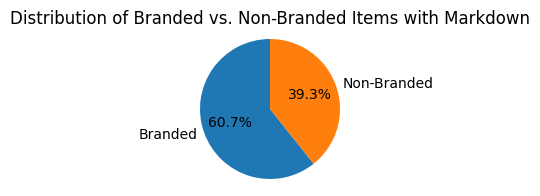

In [8]:
markdown_items = df.loc[df['Has_Markdown'] == True]
branded_markdown_count = markdown_items[markdown_items['Branded?'] == 1].shape[0]
non_branded_markdown_count = markdown_items[markdown_items['Branded?'] == 0].shape[0]

print(f"Number of branded items with markdown: {branded_markdown_count}")
print(f"Number of non-branded items with markdown: {non_branded_markdown_count}")

categories = ['Branded', 'Non-Branded']
counts = [branded_markdown_count, non_branded_markdown_count]
plt.figure(figsize=(4, 2))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e'])
plt.axis('equal')
plt.title('Distribution of Branded vs. Non-Branded Items with Markdown')
plt.show()

In [9]:
def plot_analysis(df, variable):
    plt.figure(figsize=(16, 6))
    bars = df['Percentage Markdown'].plot(kind='bar', color='coral', width=0.8)  # Increased width parameter to reduce gaps
    plt.title('Percentage of Items with Markdown by Vendor')
    plt.xlabel(variable)
    plt.ylabel('Percentage (%)')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    plt.show()

### **Vendor Specific Analysis -**

In [10]:
vendor_markdown_data = df.groupby(['Vendor', 'Has_Markdown']).size().unstack(fill_value=0)

vendor_markdown_data.columns = ['No Markdown', 'Has Markdown']
vendor_markdown_data['Total'] = vendor_markdown_data.sum(axis=1)
vendor_markdown_data['Percentage Markdown'] = (vendor_markdown_data['Has Markdown'] * 100) / vendor_markdown_data['Total']

sales_units_by_vendor_markdown = df.groupby(['Vendor', 'Has_Markdown'])[['Sales', 'Units Left']].sum()
vendor_markdown_data['Units Sold'] = df.groupby('Vendor')['Sales'].sum()
vendor_markdown_data['Units Left'] = df.groupby('Vendor')['Units Left'].sum()
vendor_markdown_data['Total Units'] = vendor_markdown_data['Units Sold'] + vendor_markdown_data['Units Left']

vendor_markdown_data = vendor_markdown_data.sort_values('Percentage Markdown', ascending=False)
vendor_markdown_data

,No Markdown,Has Markdown,Total,Percentage Markdown,Units Sold,Units Left,Total Units
Vendor,,,,,,,
1,0,5,5,100.000000,4412,565,4977
84,0,8,8,100.000000,1431,1385,2816
5,0,4,4,100.000000,4549,914,5463
42,0,3,3,100.000000,2840,27,2867
99,0,43,43,100.000000,56802,19163,75965
...,...,...,...,...,...,...,...
70,44,10,54,18.518519,36922,61067,97989
36,1,0,1,0.000000,28,114,142
21,5,0,5,0.000000,2405,7212,9617


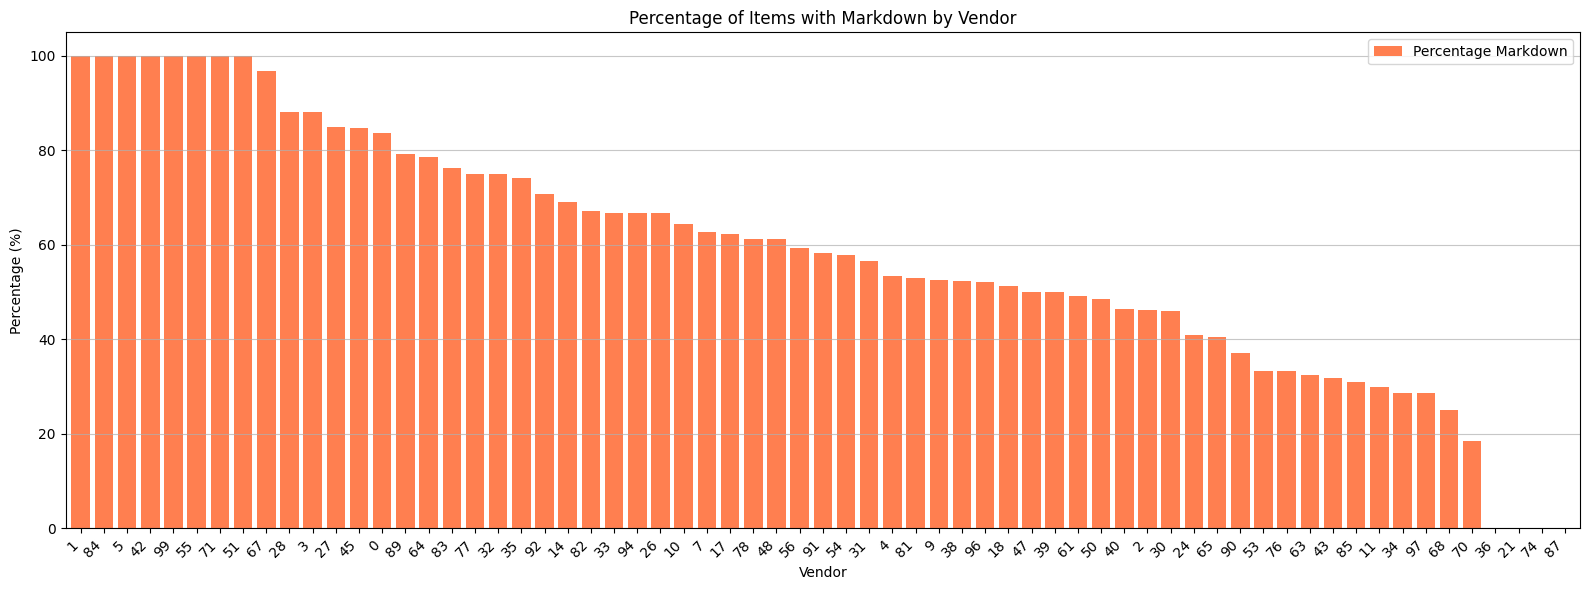

Vendors with >85% units markdown and their total units:
{1: 4977, 84: 2816, 5: 5463, 42: 2867, 99: 75965, 55: 1049, 71: 20206, 51: 1720, 67: 42878, 28: 13992, 3: 11377}

Sum total of units for vendors with >85% markdown: 308,602


In [11]:
plot_analysis(vendor_markdown_data, variable='Vendor')
high_markdown_vendors = vendor_markdown_data[vendor_markdown_data['Percentage Markdown'] > 85]['Total Units'].to_dict()

print("Vendors with >85% units markdown and their total units:")
print(high_markdown_vendors)

total_units = vendor_markdown_data[vendor_markdown_data['Percentage Markdown'] > 80]['Total Units'].sum()
print(f"\nSum total of units for vendors with >85% markdown: {total_units:,.0f}")

In [12]:
df['% LC comp. b M'] = (df['Week of Markdown'] / df['Total Lifecycle'])
df['% Inv. sold by W3'] = (df['Sales by Week 3'] / (df['Sales'] + df['Units Left']))
df['% Inv. sold'] = (df['Sales'] / (df['Sales'] + df['Units Left']))
df['Price Markup'] = (df['Initial Price'] / (df['Cost']))
df["Sales Percentage"] = (df["Sales Amount"] / df["Sales Amount"].sum())
df['Markdown'] = (df['Markdown'] / 100)
df

,ID,Branded?,Buyer,Vendor,Cost,Initial Price,Markdown,Week Available,Week of Markdown,Sales by Week 3,...,Total Lifecycle,Units Left,Sunk Cost,Has_Markdown,Revenue Left,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
0,1,1,1005,61,84.925,197.50,0.5,6,17.0,2,...,26,4,339.700,True,834.0000,0.653846,0.125000,0.750000,2.325581,0.000018
1,2,0,1011,83,144.375,460.00,NaN,46,NaN,5,...,8,3,433.125,False,-90.0000,NaN,0.312500,0.812500,3.186147,0.000072
2,3,1,1011,85,67.825,172.50,NaN,46,NaN,7,...,8,2,135.650,False,50.0000,NaN,0.388889,0.888889,2.543310,0.000032
3,4,1,1011,85,63.575,172.50,NaN,41,NaN,5,...,8,3,190.725,False,47.5000,NaN,0.277778,0.833333,2.713331,0.000030
4,5,1,1005,89,92.400,220.00,0.5,7,12.0,3,...,25,3,277.200,True,1484.0000,0.480000,0.150000,0.850000,2.380952,0.000027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4075,4076,1,1002,10,34.375,62.45,0.5,24,15.0,54,...,21,4144,142450.000,True,75111.7375,0.714286,0.007186,0.448570,1.816727,0.001597
4076,4077,1,1002,45,31.875,62.45,0.5,4,24.0,2650,...,28,1915,61040.625,True,90514.8000,0.857143,0.324000,0.765864,1.959216,0.003546
4077,4078,0,1003,18,11.000,24.95,NaN,2,NaN,960,...,26,1856,20416.000,False,-9.0818,NaN,0.109265,0.788755,2.268182,0.002039
4078,4079,0,1003,18,11.000,24.95,NaN,10,NaN,1674,...,18,3738,41118.000,False,-0.4990,NaN,0.129999,0.709715,2.268182,0.002689


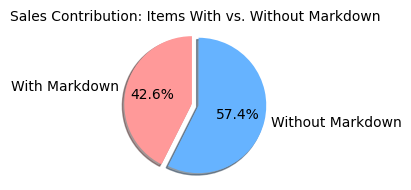

In [13]:
total_sales_sum = df['Sales Amount'].sum()
markdown_sales = df.groupby('Has_Markdown')['Sales Amount'].sum()
proportion_df = markdown_sales / total_sales_sum
sales_from_markdown_items = proportion_df['Has_Markdown' == False]
sales_with_markdown_pct = round(sales_from_markdown_items * 100, 2)
sales_without_markdown_pct = round((1 - sales_from_markdown_items) * 100, 2)

labels = ['With Markdown', 'Without Markdown']
sizes = [sales_with_markdown_pct, sales_without_markdown_pct]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.figure(figsize=(4, 2))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Sales Contribution: Items With vs. Without Markdown', fontsize=10)
plt.tight_layout()
plt.show()

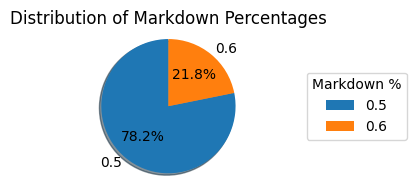

In [14]:
markdown_counts = df['Markdown'].value_counts().sort_index()

plt.figure(figsize=(4, 2))
plt.pie(markdown_counts, labels=markdown_counts.index,autopct='%1.1f%%',
        startangle=90,shadow=True)
plt.axis('equal')
plt.title('Distribution of Markdown Percentages')
plt.legend(title='Markdown %', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

### **Correlation Analysis -**

In [15]:
correlation_data = df[df['Markdown'].notna()].copy()
# Replacing 50 % Markdown with 0 and 60 % with 1 for better clustering
correlation_data['Markdown'] = correlation_data['Markdown'].replace({0.5: 0, 0.6: 1}).astype(int)
correlation_data = correlation_data.drop(columns=['ID', 'Buyer', 'Initial Price', 'Vendor', 'Week of Markdown', 'Week Available', 'Sales by Week 3', 'Sales', 'Sales Amount',
                                    'Units Left', 'Sunk Cost', 'Has_Markdown', 'Revenue Left'])
correlation_data

,Branded?,Cost,Markdown,Total Lifecycle,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
0,1,84.925,0,26,0.653846,0.125000,0.750000,2.325581,0.000018
4,1,92.400,0,25,0.480000,0.150000,0.850000,2.380952,0.000027
13,0,72.000,0,9,0.666667,0.208333,0.750000,2.500000,0.000022
14,0,78.000,0,7,0.571429,0.375000,0.833333,2.500000,0.000021
27,1,60.000,0,22,0.590909,0.433333,0.933333,2.250000,0.000024
...,...,...,...,...,...,...,...,...,...
4071,1,31.875,0,28,0.857143,0.363573,0.859583,1.959216,0.003475
4072,1,31.875,0,28,0.750000,0.096122,0.781529,1.959216,0.002582
4073,1,31.875,0,28,0.857143,0.362828,0.857619,1.959216,0.003495
4075,1,34.375,0,21,0.714286,0.007186,0.448570,1.816727,0.001597


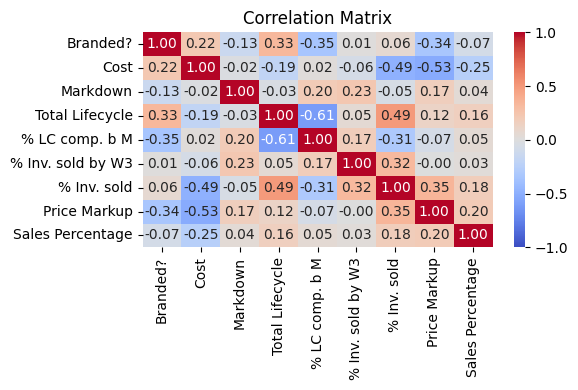

In [16]:
correlation_matrix = correlation_data.corr()

def plot_correlation(matrix):
  plt.figure(figsize=(6, 4))
  sns.heatmap(matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
  plt.title('Correlation Matrix')
  plt.tight_layout()
  plt.show()

plot_correlation(matrix=correlation_matrix)

In [17]:
correlation_data

,Branded?,Cost,Markdown,Total Lifecycle,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage
0,1,84.925,0,26,0.653846,0.125000,0.750000,2.325581,0.000018
4,1,92.400,0,25,0.480000,0.150000,0.850000,2.380952,0.000027
13,0,72.000,0,9,0.666667,0.208333,0.750000,2.500000,0.000022
14,0,78.000,0,7,0.571429,0.375000,0.833333,2.500000,0.000021
27,1,60.000,0,22,0.590909,0.433333,0.933333,2.250000,0.000024
...,...,...,...,...,...,...,...,...,...
4071,1,31.875,0,28,0.857143,0.363573,0.859583,1.959216,0.003475
4072,1,31.875,0,28,0.750000,0.096122,0.781529,1.959216,0.002582
4073,1,31.875,0,28,0.857143,0.362828,0.857619,1.959216,0.003495
4075,1,34.375,0,21,0.714286,0.007186,0.448570,1.816727,0.001597


# **CLUSTERING -**

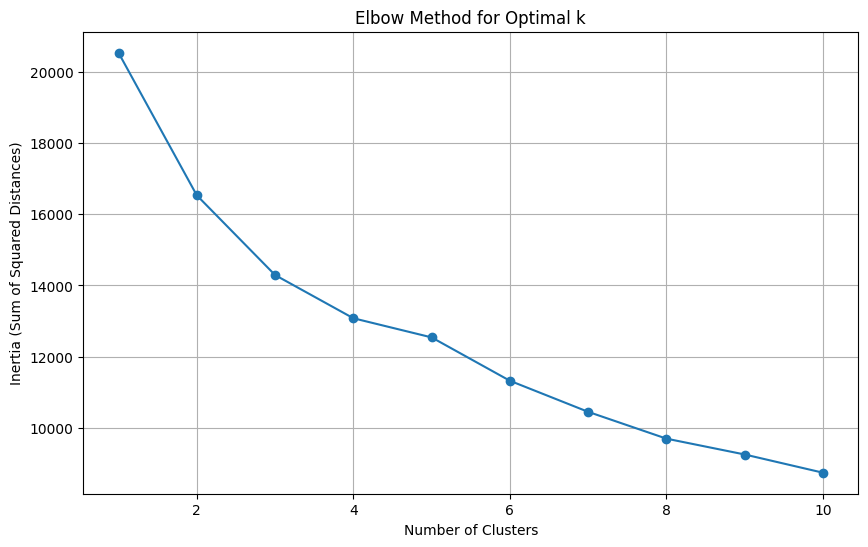

In [18]:
numerical_cols = correlation_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
data_for_clustering = correlation_data[numerical_cols].copy()

# Handling missing values (if any)
data_for_clustering = data_for_clustering.fillna(data_for_clustering.mean())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Running the Elbow Method chart - getting number of PCs
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

## **3 Clusters -**
## **Principal Component Analysis with 3 components -****

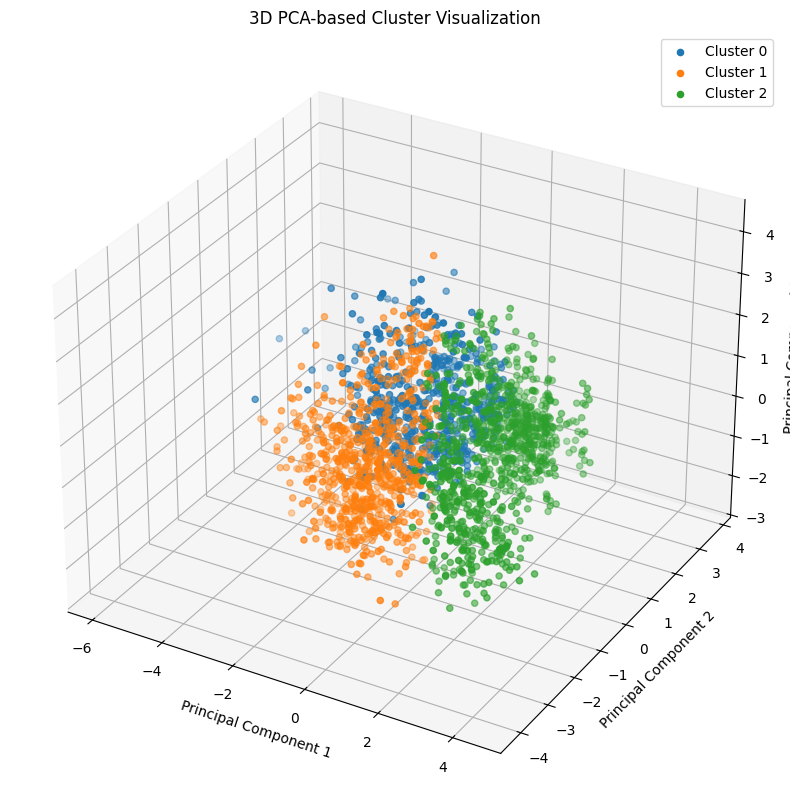

In [19]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k)
cluster_labels = kmeans.fit_predict(scaled_data)

data_for_clustering['Cluster'] = cluster_labels
cluster_summary = data_for_clustering.groupby('Cluster').mean()

pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = cluster_labels
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}')

ax.set_title('3D PCA-based Cluster Visualization')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [20]:
components = pca.components_
feature_names = correlation_data.columns
loadings = pd.DataFrame(components.T, index=feature_names, columns=['PC1', 'PC2', 'PC3'])
print("PCA Component Loadings (contributions of each feature):")
print(loadings)
explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
for i, variance in enumerate(explained_variance):
    print(f"PC{i+1}: {variance:.4f} ({variance*100:.2f}%)")
print(f"Total Variance Explained: {sum(explained_variance)*100:.2f}%")

PCA Component Loadings (contributions of each feature):
                        PC1       PC2       PC3
Branded?           0.043331  0.537373  0.250868
Cost              -0.432085  0.310898  0.180600
Markdown          -0.001124 -0.291938  0.454132
Total Lifecycle    0.459741  0.341178  0.083609
% LC comp. b M    -0.326221 -0.469804  0.161279
% Inv. sold by W3  0.121564 -0.150273  0.754097
% Inv. sold        0.532995 -0.000903  0.182471
Price Markup       0.372321 -0.369960 -0.240255
Sales Percentage   0.236974 -0.181032 -0.074380

Explained Variance Ratio:
PC1: 0.2678 (26.78%)
PC2: 0.2198 (21.98%)
PC3: 0.1385 (13.85%)
Total Variance Explained: 62.61%


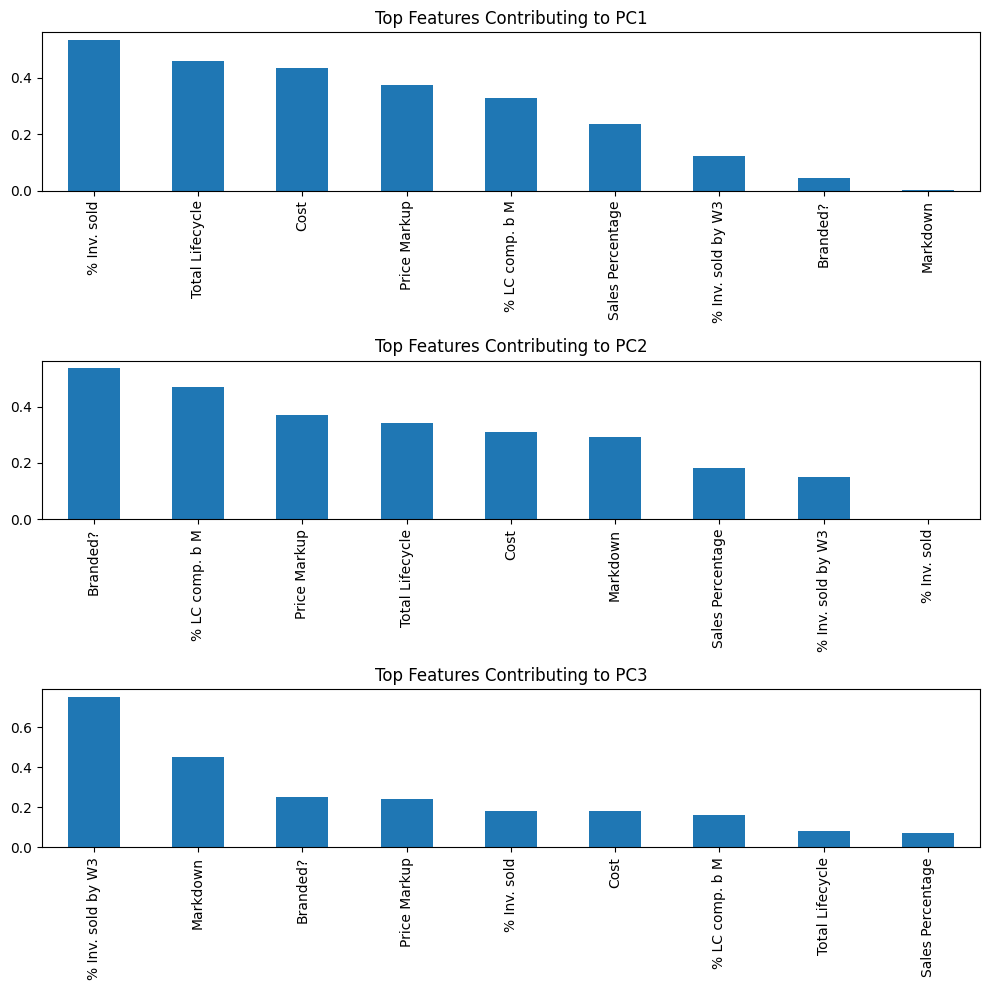

In [21]:
plt.figure(figsize=(10, 10))
for i, pc in enumerate(['PC1', 'PC2', 'PC3']):
    plt.subplot(3, 1, i+1)
    pc_loadings = loadings[pc].abs().sort_values(ascending=False)
    top_features = min(10, len(pc_loadings))
    pc_loadings[:top_features].plot(kind='bar')
    plt.title(f'Top Features Contributing to {pc}')
    plt.tight_layout()
plt.show()

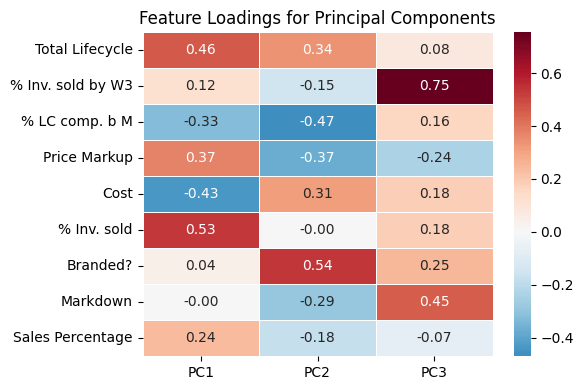

In [22]:
all_important_features = set()
for pc in ['PC1', 'PC2', 'PC3']:
    pc_loadings = loadings[pc].abs().sort_values(ascending=False)
    top_features = min(10, len(pc_loadings))
    all_important_features.update(pc_loadings[:top_features].index)
all_important_features_list = list(all_important_features)
heatmap_data = loadings.loc[all_important_features_list, ['PC1', 'PC2', 'PC3']]
plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Feature Loadings for Principal Components')
plt.tight_layout()
plt.show()

### Inventory Sold by Week 3 is an extremely important indicator for Cluster 3

In [23]:
cluster_counts = data_for_clustering['Cluster'].value_counts().sort_index()
cluster_summary['Count'] = cluster_counts
cluster_summary

,Branded?,Cost,Markdown,Total Lifecycle,% LC comp. b M,% Inv. sold by W3,% Inv. sold,Price Markup,Sales Percentage,Count
Cluster,,,,,,,,,,
0,0.986577,61.518372,0.112416,19.120805,0.486763,0.121026,0.604284,2.346042,0.000155,596
1,0.190736,43.935252,0.307902,13.529973,0.667952,0.201814,0.669941,2.638312,0.000214,734
2,0.690852,32.811278,0.215563,26.955836,0.393575,0.191410,0.906232,2.853995,0.000341,951


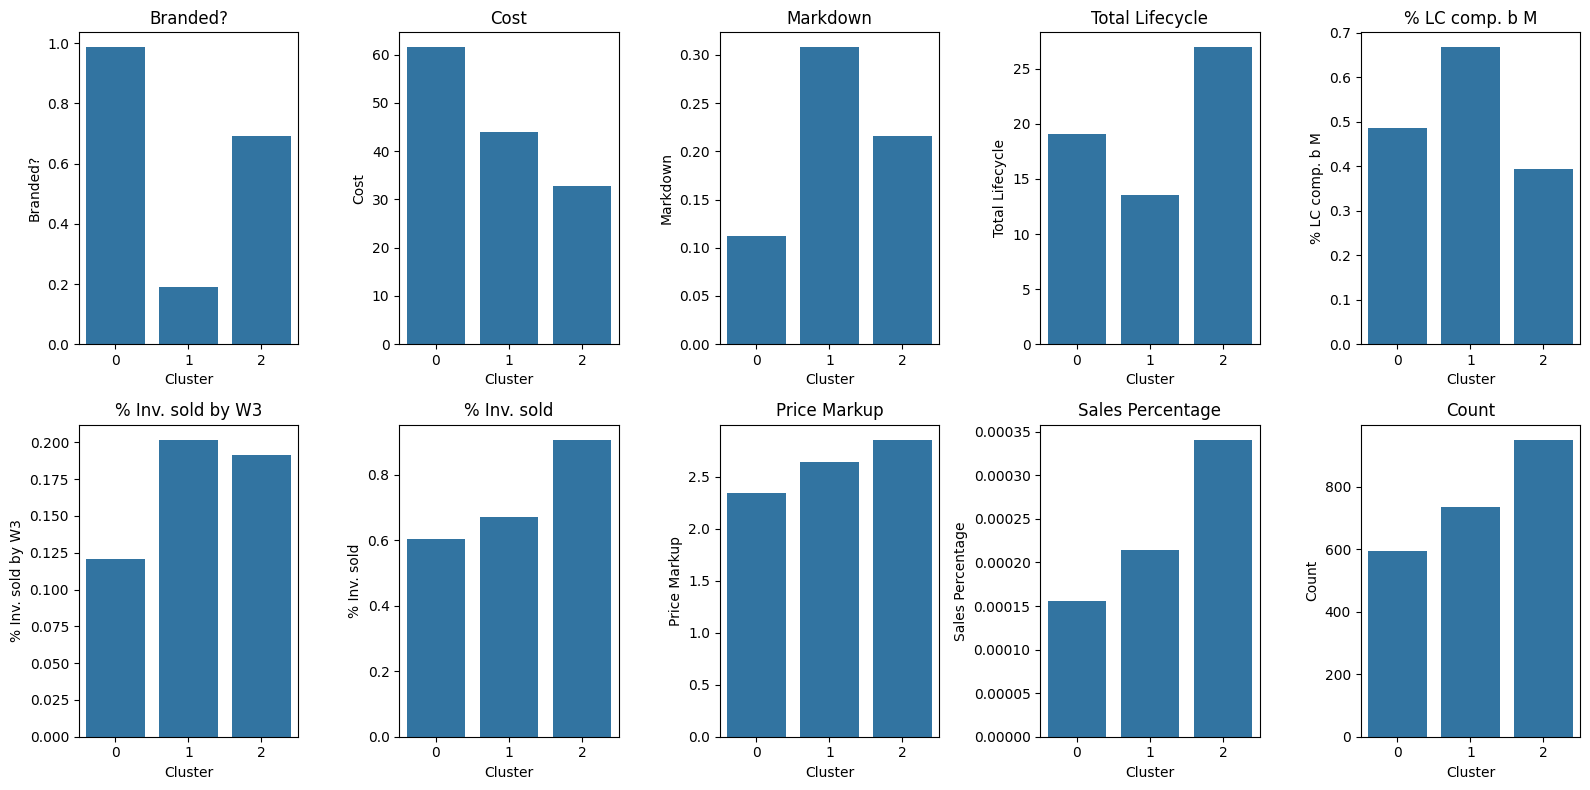

In [24]:
plt.figure(figsize=(16, 8))

for i, metric in enumerate(cluster_summary.columns):
    row = i // 5
    col = i % 5
    plt.subplot(2, 5, i+1)
    sns.barplot(x=cluster_summary.index, y=cluster_summary[metric])
    plt.title(f'{metric}')
    plt.ylabel(metric)
    plt.xlabel('Cluster')

plt.tight_layout()
plt.show()

Initial Pricing is similar for all.
### **Cluster 0 -**
* Incoming revenue is lower.
* 50% inventory is sold at the end - markdown should be earlier.
* More than 60% Lifecycle is completed before the markdown and inventory sold by week 3 is less than 15%. Hence, the markdown should definitely be earlier otherwise the product will be salvaged.

### **Cluster 2 -**
* Incoming revenue is high
* 80%+ inventory is sold at the end - markdown should be later.

* About 60% of product lifecycle is completed before the markdown. Even after this, 80%+ inventory is sold eventually. Thus, the markdown is effective. Seeing that 30% of inventory is sold by Week 3, the markdown can be delayed.

# **REGRESSION -**

In [25]:
data_for_regression = data_for_clustering[['Branded?', 'Cost', 'Price Markup', 'Total Lifecycle', '% Inv. sold by W3', 'Cluster']]
data_for_regression

,Branded?,Cost,Price Markup,Total Lifecycle,% Inv. sold by W3,Cluster
0,1,84.925,2.325581,26,0.125000,0
4,1,92.400,2.380952,25,0.150000,0
13,0,72.000,2.500000,9,0.208333,1
14,0,78.000,2.500000,7,0.375000,1
27,1,60.000,2.250000,22,0.433333,0
...,...,...,...,...,...,...
4071,1,31.875,1.959216,28,0.363573,2
4072,1,31.875,1.959216,28,0.096122,2
4073,1,31.875,1.959216,28,0.362828,2
4075,1,34.375,1.816727,21,0.007186,0


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X = data_for_regression[['Branded?', 'Cost', 'Price Markup', 'Total Lifecycle', '% Inv. sold by W3']]
y = data_for_regression['Cluster']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_val_pred = model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

y_test_pred = model.predict(X_test_scaled)
print("\n--- Final Test Results ---")
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

Validation Accuracy: 0.9166666666666666

--- Final Test Results ---
Test Accuracy: 0.8927789934354485

Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       122
           1       0.88      0.88      0.88       146
           2       0.92      0.90      0.91       189

    accuracy                           0.89       457
   macro avg       0.89      0.89      0.89       457
weighted avg       0.89      0.89      0.89       457


Feature Importance:
             Feature  Importance
3    Total Lifecycle    0.344844
1               Cost    0.221433
0           Branded?    0.170622
2       Price Markup    0.138182
4  % Inv. sold by W3    0.124919


# **Cluster Predictions with Probabilities for Items not Markdown -**

In [27]:
non_markdown = df.loc[df['Has_Markdown'] == False][['Branded?', 'Cost', 'Price Markup', 'Total Lifecycle', '% Inv. sold by W3']]
X_non_markdown_scaled = scaler.transform(non_markdown)
non_markdown_predictions = model.predict(X_non_markdown_scaled)

non_markdown['Predicted_Cluster'] = non_markdown_predictions
prediction_probabilities = model.predict_proba(X_non_markdown_scaled)

for i, cluster in enumerate(model.classes_):
    non_markdown[f'Prob_Cluster_{cluster}'] = prediction_probabilities[:, i]

print("\nPrediction distribution:")
print(non_markdown['Predicted_Cluster'].value_counts(normalize=True))
non_markdown


Prediction distribution:
Predicted_Cluster
1    0.450806
0    0.379655
2    0.169539
Name: proportion, dtype: float64


,Branded?,Cost,Price Markup,Total Lifecycle,% Inv. sold by W3,Predicted_Cluster,Prob_Cluster_0,Prob_Cluster_1,Prob_Cluster_2
1,0,144.375,3.186147,8,0.312500,1,0.19,0.81,0.00
2,1,67.825,2.543310,8,0.388889,0,0.82,0.16,0.02
3,1,63.575,2.713331,8,0.277778,1,0.38,0.61,0.01
5,1,66.250,2.566038,28,0.100000,0,0.97,0.03,0.00
6,1,90.000,2.194444,16,0.000000,0,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...
4068,0,11.000,2.268182,26,0.116014,2,0.01,0.29,0.70
4074,0,11.000,2.268182,8,0.246008,1,0.01,0.98,0.01
4077,0,11.000,2.268182,26,0.109265,2,0.01,0.28,0.71
4078,0,11.000,2.268182,18,0.129999,1,0.02,0.91,0.07
